In [38]:
# encoding: utf-8
# Author: Zhuangwei Kang

import os, sys
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
sys.path.append('../../')
from datapsr import *
import numpy as np
style.use(['classic'])
plt.rc('axes', axisbelow=True)
dpi=600

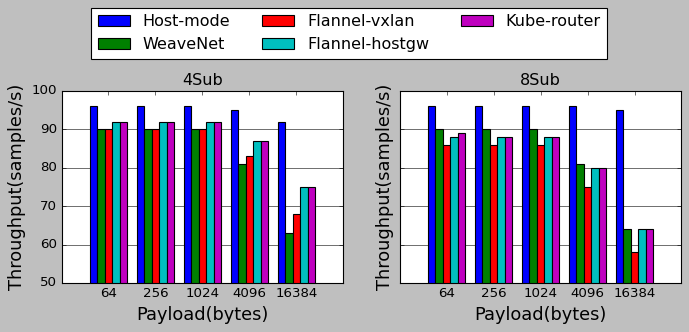

In [39]:
plugins = ['hostnetwork-udp', 'weavenet-udp', 'flannel-vxlan-udp', 'flannel-hostgw-udp', 'kube-router-udp']
data_len = [64, 256, 1024, 4096, 16384]
x = np.arange(len(data_len))
total_width, n = 0.8, len(plugins)
width = total_width / n
x_ = x
x = x - (total_width - width) / 2

multicast_test = np.arange(12, 17)
num_subs = [4, 8]
markers = ['^', 'o', 'X', 'P', 's']

# xticks=['64B', '256B', '1K', '4K', '16K']
labels = ['Host-mode', 'WeaveNet', 'Flannel-vxlan', 'Flannel-hostgw', 'Kube-router']

fig, axes2d = plt.subplots(nrows=1, ncols=2,
                           sharex=True, sharey=True, figsize=(10, 3))
ax1 = axes2d[0]
ax2 = axes2d[1]
plots=[]
throughput_perf, _ = load_data(multicast_test,  plugins, path='./4subs')
for i, cni in enumerate(plugins):
    thr = throughput_perf[throughput_perf['cni'] == cni]['packets/s(ave)']
    ax1.bar(x+i*width, thr, width=width, label=labels[i])

throughput_perf, _ = load_data(multicast_test,  plugins, path='./8subs')
for i, cni in enumerate(plugins):
    thr = throughput_perf[throughput_perf['cni'] == cni]['packets/s(ave)']
    ax2.bar(x+i*width, thr, width=width, label=labels[i])

ax1.set_xlabel('Payload(bytes)', fontsize=16)
ax1.set_ylabel('Throughput(samples/s)', fontsize=16)
ax1.grid(linestyle='-', axis='y')
ax1.set_title('4Sub')

ax2.set_xlabel('Payload(bytes)', fontsize=16)
ax2.set_ylabel('Throughput(samples/s)', fontsize=16)
ax2.grid(linestyle='-', axis='y')
ax2.set_title('8Sub')

plt.ylim(50,100)
ax1.legend(loc="center left", borderaxespad=0.1, scatterpoints = 1, bbox_to_anchor=(0.1,1.3), ncol=3)
plt.xticks(x_, data_len)
plt.savefig('throughput.png', dpi=dpi, bbox_inches='tight')


Description: in this throughput test, we run a single publisher that continuously propagates messages to 4/8 subscribers in a frequency of 10 milliseconds with the DDS Multicast QoS policy being activated. Since Flannel and Kube-router lack support of multicast, we run unicast test for them and enable multicast for hostnetwork and weavenet.

Purpose: Multicast is a crucial feature needed by Publish/Subscribe middleware, such as DDS, that is usually deployed in systems requiring one-to-many message distribution. To this end, it is necessary to understand multicast performance overhead in the Hybrid-Arch K8s deployment. Moreover, we know Kuberouter and Flannel-Hostgw perform much better than Weavenet, according to the previous CNI throughput tests. A question that needs to be answered is whether Weavenet multicast can make up for the overhead caused by VXLAN encapsulation, after then becoming a more promising solution in multi-subscriber use cases.

Analysis: The overall trend suggests that the number of delivered samples per second remains stable before 1KB and then drops down as the payload size increase. However, the degradation for virtual network plugins is more significant than that of hostnetwork. The reason is virtual network plugins need to perform more onerous packet fragmentation and encapsulation when message size is larger than MTU. When the number of subscribers grows from 4 to 8, the performance of hostnetwork and weavenet remains the same, while the degradation happens in Flannel and Kuberouter due to the nature of unicast. We can also see the curves for Kuberouter and Flannel-Hostgw overlap, meaning they have nearly the same performance. Weavenet multicast suffers 6.3%~31.5% performance overhead relative to hostnetwork. Kuberouter and Flannel-Hostgw consistently beat Weavenet multicast when running 4 subscribers, while Weavenet is more preponderant in the 8-subscriber scenario except when the payload is 16KB. Basically, the gap between Weavenet multicast and L3 virtual network solutions keeps shrinking as the increasing of message size when there are 8 subscribers. Accordingly, although Weavenet is the only CNI supporting multicast, it may not deliver the best performance comparing to Kuberouter and Flannel-Hostgw, especially in resource-constrained edge environments. The exact CNI selection decision in this case highly couples to the cluster scale and traffic load.

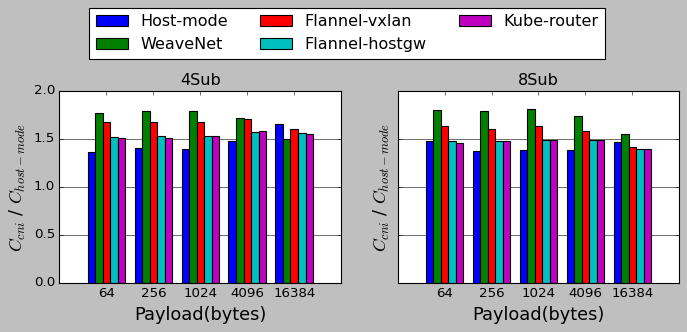

In [40]:
plugins = ['hostnetwork-udp', 'weavenet-udp', 'flannel-vxlan-udp', 'flannel-hostgw-udp', 'kube-router-udp']
data_len = [64, 256, 1024, 4096, 16384]
multicast_test = np.arange(12, 17)
num_subs = [4, 8]
markers = ['^', 'o', 'X', 'P', 's']

x = np.arange(len(data_len))
total_width, n = 0.8, len(plugins)
width = total_width / n
x_ = x
x = x - (total_width - width) / 2

xticks=['64B', '256B', '1K', '4K', '16K']
labels = ['Host-mode', 'WeaveNet', 'Flannel-vxlan', 'Flannel-hostgw', 'Kube-router']

fig, axes2d = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(10, 3))
ax1 = axes2d[0]
ax2 = axes2d[1]

throughput_perf, _ = load_data(multicast_test,  plugins, path='./4subs')
for i, cni in enumerate(plugins):
    thr = throughput_perf[throughput_perf['cni'] == cni]['cpu']
    ax1.bar(x+i*width, thr, width=width, label=labels[i])
    
throughput_perf, _ = load_data(multicast_test,  plugins, path='./8subs')
for i, cni in enumerate(plugins):
    thr = throughput_perf[throughput_perf['cni'] == cni]['cpu']
    ax2.bar(x+i*width, thr, width=width, label=labels[i])

ax1.set_xlabel('Payload(bytes)', fontsize=16)
ax1.set_ylabel('$C_{cni}$ / $C_{host-mode}$', fontsize=16)
ax1.grid(linestyle='-',axis='y')
ax1.set_title('4Sub')

ax2.set_xlabel('Payload(bytes)', fontsize=16)
ax2.set_ylabel('$C_{cni}$ / $C_{host-mode}$', fontsize=16)
ax2.grid(linestyle='-', axis='y')
ax2.set_title('8Sub')

ax1.legend(loc="center left", borderaxespad=0.1, scatterpoints = 1, bbox_to_anchor=(0.1,1.3), ncol=3)
plt.xticks(x_, data_len)
# plt.yticks(np.arange(6,11, 1)/10, np.arange(6,11, 1)/10)
plt.savefig('cpu.png', dpi=dpi, bbox_inches='tight')


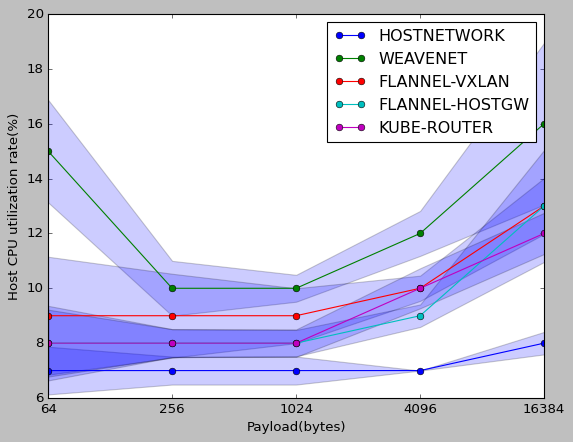

In [41]:

plt.xticks(range(len(data_len)), data_len)
for cni in plugins:
    pub_cpu = []
    pub_cpu_std = []
    sub_cpu = []
    sub_cpu_std = []
    for i in range(len(data_len)):
        data = pd.read_csv('4subs/throughputTest/%s/test-%d/metrics.csv' % (cni, 12+i))
        pub_cpu.append(data[data['name'] == 'raspberrypi87']['cpu%(90%)'])
        sub_cpu.append(data[data['name'] == 'raspberrypi89']['cpu%(90%)'])
        pub_cpu_std.append(data[data['name'] == 'raspberrypi87']['cpu%(std)'])
        sub_cpu_std.append(data[data['name'] == 'raspberrypi89']['cpu%(std)'])
    plt.plot(np.arange(len(data_len)), pub_cpu, label='-'.join(cni.split('-')[:-1]).upper(), marker='o')
    plt.fill_between(np.arange(len(data_len)), np.reshape(np.array(pub_cpu)-np.array(pub_cpu_std), len(data_len)), np.reshape(np.array(pub_cpu)+np.array(pub_cpu_std), len(data_len)), alpha=.2)

# plt.ylim(0, 100)
plt.legend()
plt.xlabel('Payload(bytes)')
plt.ylabel('Host CPU utilization rate(%)')
# plt.grid(axis='y', linestyle=':')
plt.show()

      cpu  99_9999%   99_99%      99%      90%      50%      max      min  \
0   10.92   17129.0   6178.0   1114.0    768.0    595.0  17129.0    390.0   
1   10.46   52704.0   5956.0   1179.0    826.0    651.0  52704.0    433.0   
2    9.41   15319.0   6993.0   1443.0   1034.0    851.0  15319.0    609.0   
3    8.76   14452.0   7434.0   1859.0   1419.0   1251.0  14452.0    977.0   
4    7.64   19831.0  10574.0   4003.0   3234.0   2346.0  19831.0   2037.0   
5    5.68   20470.0  20470.0   2625.0   1606.0   1303.0  20470.0    794.0   
6    5.61   25901.0  25901.0   2412.0   1648.0   1351.0  25901.0    853.0   
7    5.39   15807.0  15807.0   2737.0   2045.0   1735.0  15807.0   1143.0   
8    5.64   18459.0  18459.0   5391.0   4765.0   4389.0  18459.0   3637.0   
9    6.41   26773.0  26773.0  15976.0  15359.0  14824.0  26773.0  13745.0   
10   5.40   18714.0  18714.0   2205.0   1395.0   1079.0  18714.0    649.0   
11   5.39   11566.0  11566.0   2334.0   1439.0   1127.0  11566.0    692.0   

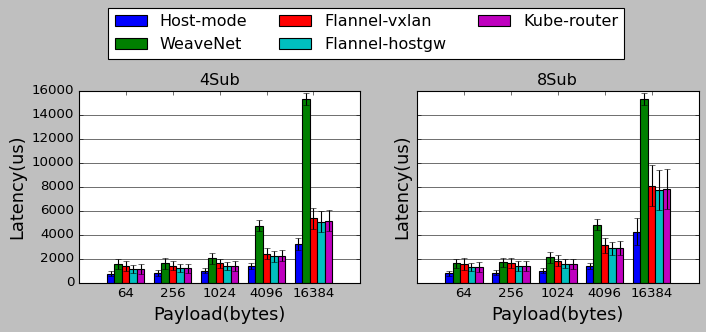

In [42]:
plugins = ['hostnetwork-udp', 'weavenet-udp', 'flannel-vxlan-udp', 'flannel-hostgw-udp', 'kube-router-udp']
data_len = [64, 256, 1024, 4096, 16384]
multicast_test = np.arange(12, 17)
num_subs = [4, 8]
markers = ['^', 'o', 'X', 'P', 's']


x = np.arange(len(data_len))
# plt.xticks(x, data_len)
total_width, n = 0.8, len(plugins)
width = total_width / n
x_ = x
x = x - (total_width - width) / 2

labels = ['Host-mode', 'WeaveNet', 'Flannel-vxlan', 'Flannel-hostgw', 'Kube-router']
fig, axes2d = plt.subplots(nrows=1, ncols=2,
                           sharex=True, sharey=True, figsize=(10, 3))
ax1 = axes2d[0]
ax2 = axes2d[1]
plots=[]
_, latency_perf = load_data(multicast_test,  plugins, path='./4subs', latencyTest=True)
print(latency_perf)
for i, cni in enumerate(plugins):
    lat = latency_perf[latency_perf['cni'] == cni]['90%']
    lat_err = latency_perf[latency_perf['cni'] == cni]['std']
    ax1.bar(x+i*width, lat, yerr=lat_err, width=width, label=labels[i])

_, latency_perf = load_data(multicast_test,  plugins, path='./8subs', latencyTest=True)
# print(latency_perf)
for i, cni in enumerate(plugins):
    lat = latency_perf[latency_perf['cni'] == cni]['90%']
    lat_err = latency_perf[latency_perf['cni'] == cni]['std']
    ax2.bar(x+i*width, lat, yerr=lat_err, width=width, label=labels[i])

# plt.ylim(50,100)
ax1.legend(loc="center left", borderaxespad=0.1, scatterpoints = 1, bbox_to_anchor=(0.1,1.3), ncol=3)
plt.xticks(x_, data_len)
# plt.yticks(np.arange(6,11, 1)/10, np.arange(6,11, 1)/10)

ax1.set_xlabel('Payload(bytes)', fontsize=16)
ax1.set_ylabel('Latency(us)', fontsize=16)
ax1.grid(linestyle='-', axis='y')
ax1.set_title('4Sub')

ax2.set_xlabel('Payload(bytes)', fontsize=16)
ax2.set_ylabel('Latency(us)', fontsize=16)
ax2.grid(linestyle='-', axis='y')
ax2.set_title('8Sub')

plt.savefig('latency.png', dpi=dpi, bbox_inches='tight')